<a href="https://colab.research.google.com/github/ngalo-coder/Frappe-ERPNext-Version-15--in-Ubuntu-22.04-LTS/blob/main/notebooks/terramind_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup
In colab:

Go to "Runtime" -> "Change runtime type" -> Select "T4 GPU"
Install TerraTorch

In [1]:
%%time
# ── 1. Install Python/Modules/System dependencies ─────────────────────────────
# terratorch 1.0.1 is what the notebooks were written against
# git-lfs is needed because the GeoTIFFs in examples/ are stored with LFS
!pip install --upgrade pip
!pip install terratorch==1.0.1
!pip install gdown
!pip install git+https://github.com/huggingface/huggingface_hub
!pip install torch

base_url = (
  "https://raw.githubusercontent.com/"
  "eugenegene/terramind/colab_compat/notebooks/"
)
!wget {base_url}plotting_utils.py

!git lfs install

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 134.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 850.8/850.8 kB 48.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 53.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 52.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 144.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 119.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 26.6 MB/s  0:00:10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 151.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 129.8 MB/s  0:00:00
   ━━

In [2]:
%%time
# ── 2. Data ───────────────────────────────────────────────────────────────────
# Pull the repo (only the examples/ folder)
# --depth=1 keeps the clone quick;
# --branch selects the colab_compat branch
!git clone --depth 1 --filter=blob:none --sparse \
      --branch colab_compat https://github.com/EugeneGene/terramind.git
# check out just the examples/ subtree only
# cd back to root
%cd terramind
!git sparse-checkout set examples
%cd ..

Cloning into 'terramind'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 0), reused 12 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), done.
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (4/4), 11.65 KiB | 248.00 KiB/s, done.
/content/terramind
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 35 (delta 1), reused 35 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 8.03 MiB | 11.67 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (39/39), done.
/content
CPU times: user 13.9 ms, sys: 2.07 ms, total: 16 ms
Wall time: 2.32 s


# TerraMind Generation
TerraMind is the first Geospatial Foundation Model (GeoFM/GFM) built with the ability to generate any modality from any other, such as predicting cloud-penetrating Sentinel-1 radar from Sentinel-2 optical, or inferring land cover maps directly from raw satellite imagery. This multimodal versatility is enabled by its architecture and training setup, which learns a shared latent space across all supported input-output combinations.


This example demonstrates any-to-many generation, where a single input modality—Sentinel-2 L2A—is used to generate multiple outputs simultaneously:
Sentinel-1 GRD, DEM, LULC, NDVI, and a self-reconstruction of the input S2L2A.

This notebook showcases TerraMind’s powerful multimodal generative capabilities, enabling broad geospatial applications such as cross-sensor prediction, synthetic modality filling, and land cover estimation from incomplete data.

In [3]:
import torch
import rioxarray as rxr
import matplotlib.pyplot as plt
from terratorch.registry import FULL_MODEL_REGISTRY
from plotting_utils import plot_s2, plot_modality

# If you need the standardization values, use:
from terratorch.models.backbones.terramind.model.terramind_register import (
    v1_pretraining_mean,
    v1_pretraining_std
)

# Select device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

device

'cuda'

## Model Initialization
We build the pretrained TerraMind base model using terramind_v1_base_generate. The input modality is set to Sentinel-2 L2A, and the outputs include 5 target modalities. Standardization is handled internally.

In [4]:
%%time
# Build model that generates S-2 L2A (via tokenizer), S-1 GRD, DEM, LULC, and NDVI based on raw S-2 L2A input:
model = FULL_MODEL_REGISTRY.build(
    'terramind_v1_base_generate',
    modalities=['S2L2A'],  # Define the input
    output_modalities=['S2L2A', 'S1GRD', 'DEM', 'LULC', 'NDVI'],  # Define the output
    pretrained=True,
    standardize=True,  # If standardize=True, you don't need to do the standardization yourself.
    # offset={'S2L2A': 1000}  # Optional offset in your data. The offset is also applied to the generation.
)

_ = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


TerraMind_Tokenizer_S2L2A.pt:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

TerraMind_Tokenizer_S1GRD.pt:   0%|          | 0.00/1.15G [00:00<?, ?B/s]

TerraMind_Tokenizer_DEM.pt:   0%|          | 0.00/1.15G [00:00<?, ?B/s]

TerraMind_Tokenizer_LULC.pt:   0%|          | 0.00/736M [00:00<?, ?B/s]

TerraMind_Tokenizer_NDVI.pt:   0%|          | 0.00/1.15G [00:00<?, ?B/s]

TerraMind_v1_base.pt:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

CPU times: user 47.9 s, sys: 37 s, total: 1min 24s
Wall time: 6min 52s


## Input Preparation
A Sentinel-2 L2A image is loaded from the provided examples and reshaped to the model's expected input format ([B, C, 224, 224]). The RGB visualization of the input is rendered using plot_s2.

In [5]:
# Load an S-2 L2A example
examples = [
    'terramind/examples/S2L2A/38D_378R_2_3.tif',
    'terramind/examples/S2L2A/282D_485L_3_3.tif',
    'terramind/examples/S2L2A/433D_629L_3_1.tif',
    'terramind/examples/S2L2A/637U_59R_1_3.tif',
    'terramind/examples/S2L2A/609U_541L_3_0.tif',
]

# Select example between 0 and 4
data = rxr.open_rasterio(examples[4])
# Convert to shape [B, C, 224, 224]
data = torch.Tensor(data.values, device='cpu').unsqueeze(0)

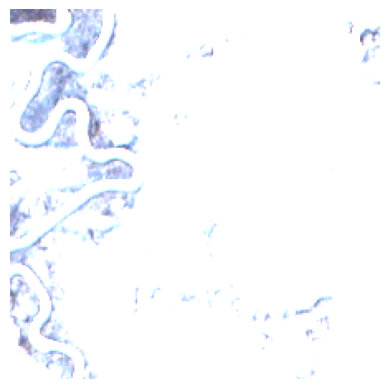

In [6]:
# Visualize S-2 L2A input as RGB
plot_s2(data)

## Multimodal Generation
The input is passed through the model with 15 diffusion steps. TerraMind then generates the target modalities simultaneously from the shared latent space.



In [7]:
%%time
# Run model with diffusion steps
input = data.to(device)
with torch.no_grad():
  generated = model(input, verbose=True, timesteps=15)

100%|██████████| 16/16 [00:00<00:00, 17.49it/s]

CPU times: user 4.38 s, sys: 47.6 ms, total: 4.43 s
Wall time: 6.2 s


## Visualization
The input and all generated outputs are displayed side-by-side for visual inspection, demonstrating the model’s ability to reconstruct diverse data types from a single optical input.

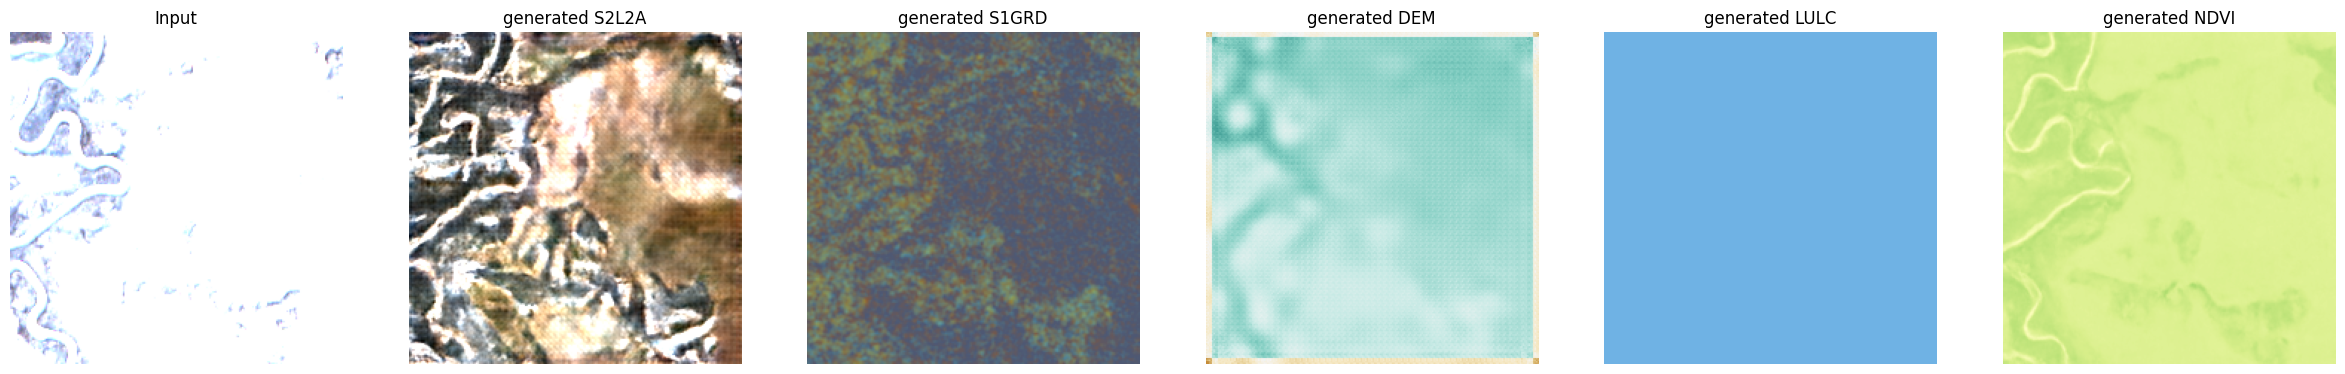

In [8]:
# Plot generations
n_plots = len(generated) + 1
fig, ax = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5))

plot_s2(input, ax=ax[0])
ax[0].set_title('Input')

for i, (mod, value) in enumerate(generated.items()):
    plot_modality(mod, value, ax=ax[i + 1])

    ax[i+1].set_title('generated ' + mod)

plt.show()